# Training agents among peers 

In the previous notebooks, we trained one agent to move among 19 other agents controlled by the fixed, well-performing, `HL` policy.

In this notebook, we keep the same scenario but change environenment and task: all the 20 agents learn to navigate among peers. This change does impact the two IL algorithms we are using differently:

- it does not impact `BC` at all: the expert(s) are still `HL` agents navigating among `HL` agents
- it does impact `DAgger`: in some of the samples, the neighbors will be controlled by the policy, while in the single-agent environment, the neighbors where always following `HL`.

For RL algorithms, this change means instead that no agents will not use the behavior (`HL`) specified in the scenario, which we could therefore leave unspecified.

## Environment

Let is start by loading the Gymnasium environment from the previous notebooks, where we control a sigle agent.

In [1]:
import warnings
from navground.learning import io

warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['svg']

env = io.load_env('env.yaml') 
expert = env.unwrapped.policy

Altough we don't use it direcly in this notebook, it stores configuration (scenario, sensor, actions, observations, time step, duration and reward) that we want to resuse for the multi-agent environment, which is what the helper function `make_shared_parallel_env_with_env` does.

In [2]:
from navground.learning.parallel_env import make_shared_parallel_env_with_env

penv = make_shared_parallel_env_with_env(env=env)
io.save_env(penv, 'parallel_env.yaml')
penv.possible_agents

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In the Parallel PettingZoo environment `penv` observations, actions and rewards of all 20 agents are exposed. 

The ML algorithms we are using do not support `PettingZoo` environments directly. Instead they are designed for `Gymnasium` environment, or, more precisely, for the type of vectorized enviroments defined by `[StableBaseline3 API](https://stable-baselines3.readthedocs.io/en/master)`.

As explained in the [introduction](../../introduction.rst), we can see a single parallel enviromenent with multiple agent as a stack of multiple environments with a single agents. Functions like `make_vec_from_penv` creates a *view* of the parallel environment as a vectorized environment.

In [3]:
from navground.learning.parallel_env import make_vec_from_penv

venv = make_vec_from_penv(penv)
venv.num_envs, venv.action_space

(20, Box(-1.0, 1.0, (2,), float32))

Observations, actions and rewards that in the parallel environment are dictionaries indexed by integer keys, becomes arrays, like

`{1: value_1, 2: value_2, ...}` -> `[value_1, value_2, ...]`

`venv` is just a view: all the "action" happens in `penv`.

## Pre-trained SA policies

In the [previous notebook](./Analysis-SA.rst), we have already computed the performance of the [policies trained](./Training-SA.rst) in `env`, but we have skipped the case with 20 policy agents and no `HL` agent. 

In [4]:
from navground.learning.evaluation import evaluate_policy

mean = {}
stddev = {}
mean['HL'], stddev['HL']  = evaluate_policy(expert, venv, n_eval_episodes=100)

In [5]:
from navground.learning import onnx
from navground.learning.il import BC, DAgger
from stable_baselines3 import SAC

for cls in (BC, DAgger, SAC):
    name = cls.__name__
    model = cls.load(f'{name}/model')
    mean[name], stddev[name] = evaluate_policy(model.policy, venv, n_eval_episodes=100)

In [6]:
import pandas as pd

pd.set_option("display.precision", 3)
rewards = pd.DataFrame({"mean": mean, "std dev": stddev})
rewards.index = rewards.index.set_names(['algorithm'])
rewards / 600

,mean,std dev
algorithm,,
HL,-0.225,0.041
BC,-0.936,0.228
DAgger,-0.641,0.166
SAC,-0.614,0.190


We can use them as baseline for the policies we are going to train.

## Training

Uncomment the next cells (if you have installed `tensorboard`) to visualize the logs during training.

In [7]:
# %load_ext tensorboard

In [8]:
# %tensorboard --logdir logs

We record the current time stamp to avoid overwriting the logs

In [9]:
from datetime import datetime as dt

stamp = dt.now().strftime("%Y%m%d_%H%M%S")

### Behavior Cloning

As we noted above, we do not expect statistical significant differences when training with Behavior Cloning in `penv` compared to `env`. Nonetheless, we train a `P-BC` policy (`P` stands for parallel) and check its performance.

For all algorithms, we keep the same neural network model with two layers of 256 neurons each, like done for the policies trained in `env`.

In [10]:
from navground.learning.il import BC, make_vec_from_penv, setup_tqdm
from imitation.util import logger

setup_tqdm()

test_venv = make_vec_from_penv(penv, num_envs=1)
training_venv = make_vec_from_penv(penv, num_envs=1)
bc = BC(training_venv, expert=expert, policy_kwargs=dict(net_arch=[256, 256]), 
        bc_kwargs={'l2_weight': 1e-6, 'ent_weight': 1e-2, 'batch_size': 128})
bc.logger = logger.configure(f"logs/P-BC/{stamp}", ['tensorboard', 'csv'])

Let us train the policy for a while.

In [11]:
import time

start = time.time()
bc.collect_runs(2000)
print(f'Collecting runs took {time.time() - start: .0f} seconds')
start = time.time()
bc.learn(
    log_rollouts_venv=test_venv, 
    log_rollouts_n_episodes=10,
    log_interval=250,
    n_epochs=1,
    progress_bar=True
)
print(f'Training took {time.time() - start: .0f} seconds')
bc.save("P-BC/model")

0batch [00:00, ?batch/s]

Training took  48 seconds


Collecting the runs is now faster, as it requires less navground simulations (1 multi-agent run is equivalent to 20 single-agent runs). 

In the plot, we add lines for the `BC` baseline (dashed) and for `HL` (dotted).

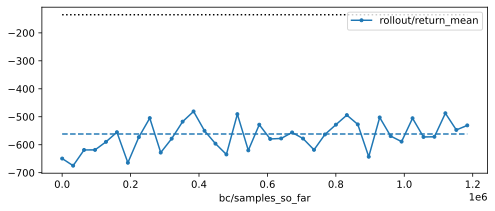

In [14]:
from matplotlib import pyplot as plt

df = pd.read_csv(f'{bc.logger.get_dir()}/progress.csv')
df.plot(y='rollout/return_mean', x='bc/samples_so_far', figsize=(8, 3), marker=".");
plt.hlines(mean['BC'], 0, df['bc/samples_so_far'].max(), linestyle='--')
plt.hlines(mean['HL'], 0, df['bc/samples_so_far'].max(), linestyle=':', color='k');

In [15]:
mean['P-BC'], stddev['P-BC'] = evaluate_policy(bc.policy, test_venv, n_eval_episodes=100)
print(f"P-BC: {mean['P-BC'] / 600: .2f} ± {stddev['P-BC'] / 600: .2f}")

P-BC: -1.01 ±  0.25


with a performance that is comparable to the original `BC` policy trained in `env` and not better than a random policy.

### DAgger

In [16]:
from navground.learning.il import DAgger

bc_kwargs = {'l2_weight': 1e-6, 'ent_weight': 1e-2, 'batch_size': 128}
dagger = DAgger(training_venv, expert=expert, 
                policy_kwargs=dict(net_arch=[256, 256]), 
                bc_kwargs=bc_kwargs) 
dagger.logger = logger.configure(f"logs/P-DAgger/{stamp}", ['tensorboard', 'csv'])

In [17]:
import time

start = time.time()
dagger.learn(
    total_timesteps=750_000,
    rollout_round_min_episodes=10,
    bc_train_kwargs={
        'log_rollouts_venv': test_venv, 
        'log_rollouts_n_episodes': 10,
        'log_interval': 1000,
        'n_epochs': 1,
        'progress_bar': False,
    },
    progress_bar=True
)
print(f'Training took {time.time() - start: .0f} seconds')
dagger.save("P-DAgger/model.zip")

Output()

Training took  663 seconds


About 400K steps are enough to learn the policy, i.e., more sample than the original `DAgger` trained in `env`. Yet, when comparing steps done by single agents training in `penv` requires about half (20K) of the steps of `env` (40K). In the plot, we add lines for the `DAgger` baseline (dashed) and for `HL` (dotted).

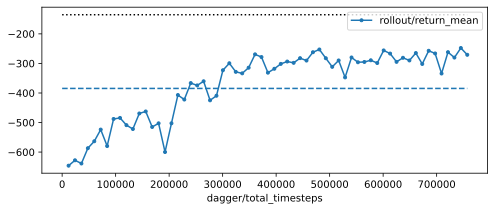

In [18]:
df = pd.read_csv(f'{dagger.logger.get_dir()}/progress.csv')
df = df.dropna()
df.plot(y='rollout/return_mean', x='dagger/total_timesteps', figsize=(8, 3), marker=".");
plt.hlines(mean['DAgger'], 0, df['dagger/total_timesteps'].max(), linestyle='--')
plt.hlines(mean['HL'], 0, df['dagger/total_timesteps'].max(), linestyle=':', color='k')

In [19]:
mean['P-DAgger'], stddev['P-DAgger'] = evaluate_policy(dagger.policy, test_venv, n_eval_episodes=200)
print(f"P-DAgger: {mean['P-DAgger'] / 600: .2f} ± {stddev['P-DAgger'] / 600: .2f}")

P-DAgger: -0.42 ±  0.10


The performance of `P-DAgger` is significantly better than `DAgger`, altough it does not reach `HL`.

### SAC

In [20]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import VecMonitor
from navground.learning.parallel_env import make_vec_from_penv
from stable_baselines3.common.logger import configure

training_venv = VecMonitor(make_vec_from_penv(penv))
sac = SAC("MlpPolicy", training_venv, verbose=0, policy_kwargs=dict(net_arch=[256, 256]))
sac.set_logger(configure(f'logs/P-SAC/{stamp}', ["csv", "tensorboard"]))

In [21]:
start = time.time()
sac.learn(total_timesteps=750_000, progress_bar=True, tb_log_name="SAC",
          log_interval=25);
print(f'Training took {time.time() - start: .0f} seconds')
sac.save("P-SAC/model.zip")

Output()

Training took  227 seconds


Training in `penv` requires significanlty more steps than in `env` but takes a much shorter time. A similar number of steps per agent are required (about 30K).

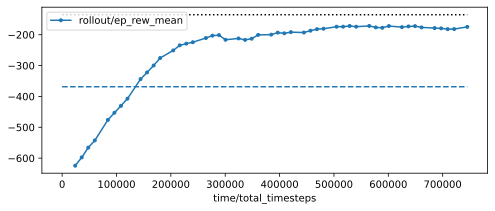

In [22]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv(f'{sac.logger.get_dir()}/progress.csv')
df.plot(y='rollout/ep_rew_mean', x='time/total_timesteps', figsize=(8, 3), marker=".");
plt.hlines(mean['SAC'], 0, df['time/total_timesteps'].max(), linestyle='--')
plt.hlines(mean['HL'], 0, df['time/total_timesteps'].max(), linestyle=':', color='k')

In [23]:
mean['P-SAC'], stddev['P-SAC'] = evaluate_policy(sac.policy, test_venv, n_eval_episodes=100)
print(f"P-SAC: {mean['P-SAC'] / 600: .2f} ± {stddev['P-SAC'] / 600: .2f}")

P-SAC: -0.28 ±  0.06


The performance of `P-SAC` is much better than `SAC` and almost reaches `HL` (-0.22), altough it remains higher than the perfomance of a single `SAC` agent among 19 `HL` agents (-0.16) as now the policy agents must take full responsibility for avoiding a collision, and can not optimize their rewards at the expense of other agents.

## Summary

We successfully trained three policies with three different algorithms in the parallel multi-agent environment. As expected, this brings no no difference for `BC`. Instead, for `DAgger` and `SAC`, it leads to significalty better performances, that are almost comparable to the original `HL` behavior.  

In [24]:
rewards = pd.DataFrame({"mean": mean, "std dev": stddev})
rewards.index = rewards.index.set_names(['algorithm'])
rewards /= 600
rewards.to_csv("rewards_ma.csv")
rewards

,mean,std dev
algorithm,,
HL,-0.225,0.041
BC,-0.936,0.228
DAgger,-0.641,0.166
SAC,-0.614,0.190
P-BC,-1.007,0.246
P-DAgger,-0.415,0.101
P-SAC,-0.281,0.064


It the plot below, we rescale the reward to that 1 is the theoretical upper-bound and 0 is the reward of random.

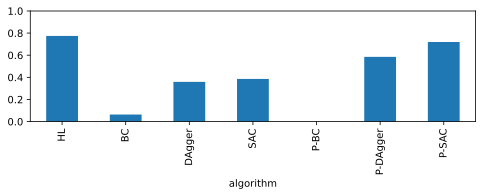

In [25]:
from matplotlib import pyplot as plt

(1 + rewards['mean']).plot.bar(figsize=(8, 2));
plt.ylim(0, 1);

The next notebook, we complete the serie by analysing the performance of the policies trained in the parallel environment when applied in a mixed group where some of the agents follows `HL`, like we have already done for the policies trained in the original single-agent environment.